In [1]:
import pandas as pd
import numpy as np
import sys
import lifelines
import random
from lifelines import KaplanMeierFitter
from lifelines import CoxPHFitter
from lifelines.statistics import logrank_test
from scipy.stats import pearsonr, spearmanr, mannwhitneyu, kruskal, ttest_ind

import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style('white')
%matplotlib inline
import statsmodels.stats.multitest as multi
from matplotlib.collections import PatchCollection
import matplotlib
matplotlib.rcParams['pdf.fonttype'] = 42
matplotlib.rcParams['ps.fonttype'] = 42

In [2]:
onco_meqtls = pd.read_csv("coxph/oncogene_meqtls.csv")
tsg_meqtls = pd.read_csv("coxph/tsg_meqtls.csv")
del onco_meqtls["Unnamed: 0"]
del tsg_meqtls["Unnamed: 0"]
onco_meqtls

,snp,chr,bp,TAD_TYPE,alleles,P,SNP
0,rs17519536,chr15,50763627,Boundary,A/G,3.620000e-34,15:50763627:A:G
1,rs17519536,chr15,50763627,Boundary,A/G,3.620000e-34,15:50763627:G:A
2,rs12439248,chr15,50768308,Boundary,G/A,3.620000e-34,15:50768308:G:A
3,rs12439248,chr15,50768308,Boundary,G/A,3.620000e-34,15:50768308:A:G
4,rs11633624,chr15,50768720,Boundary,A/G,3.620000e-34,15:50768720:A:G
...,...,...,...,...,...,...,...
2089,rs10177911,chr2,137043076,Boundary,A/G,4.920000e-06,2:137043076:G:A
2090,rs1722404,chr2,16880977,Boundary,G/A,7.540000e-06,2:16880977:G:A
2091,rs1722404,chr2,16880977,Boundary,G/A,7.540000e-06,2:16880977:A:G
2092,rs371714190,chr1,11309434,Active,CT/C,9.510000e-06,1:11309434:CT:C


In [5]:
tsg_meqtls

,snp,chr,bp,TAD_TYPE,alleles,P,SNP
0,rs6500442,chr16,89828862,Active,T/C,6.350000e-46,16:89828862:T:C
1,rs6500442,chr16,89828862,Active,T/C,6.350000e-46,16:89828862:C:T
2,rs6500441,chr16,89828669,Active,C/G,3.360000e-45,16:89828669:C:G
3,rs6500441,chr16,89828669,Active,C/G,3.360000e-45,16:89828669:G:C
4,rs1800287,chr16,89858525,Active,C/G,4.360000e-44,16:89858525:C:G
...,...,...,...,...,...,...,...
6369,rs4920398,chr1,18257264,Boundary,G/C,9.630000e-06,1:18257264:C:G
6370,rs7602836,chr2,25244377,Boundary,C/T,9.660000e-06,2:25244377:C:T
6371,rs7602836,chr2,25244377,Boundary,C/T,9.660000e-06,2:25244377:T:C
6372,rs73459968,chr7,145991556,Neither,C/T,9.770000e-06,7:145991556:C:T


In [6]:
onco_meqtls = onco_meqtls.drop_duplicates(subset=["snp"])
tsg_meqtls = tsg_meqtls.drop_duplicates(subset=["snp"])
onco_meqtls

,snp,chr,bp,TAD_TYPE,alleles,P,SNP
0,rs17519536,chr15,50763627,Boundary,A/G,3.620000e-34,15:50763627:A:G
2,rs12439248,chr15,50768308,Boundary,G/A,3.620000e-34,15:50768308:G:A
4,rs11633624,chr15,50768720,Boundary,A/G,3.620000e-34,15:50768720:A:G
6,rs11638198,chr15,50765087,Boundary,G/A,4.120000e-34,15:50765087:G:A
8,rs62019087,chr15,50767699,Boundary,C/T,4.120000e-34,15:50767699:C:T
...,...,...,...,...,...,...,...
2084,rs6690493,chr1,12135526,Boundary,C/T,4.240000e-06,1:12135526:C:T
2086,rs10141758,chr14,62009010,Boundary,C/A,4.410000e-06,14:62009010:C:A
2088,rs10177911,chr2,137043076,Boundary,A/G,4.920000e-06,2:137043076:A:G
2090,rs1722404,chr2,16880977,Boundary,G/A,7.540000e-06,2:16880977:G:A


In [3]:
frames = [onco_meqtls, tsg_meqtls]
cancer_meqtls = pd.concat(frames)
cancer_meqtls

,snp,chr,bp,TAD_TYPE,alleles,P,SNP
0,rs17519536,chr15,50763627,Boundary,A/G,3.620000e-34,15:50763627:A:G
1,rs17519536,chr15,50763627,Boundary,A/G,3.620000e-34,15:50763627:G:A
2,rs12439248,chr15,50768308,Boundary,G/A,3.620000e-34,15:50768308:G:A
3,rs12439248,chr15,50768308,Boundary,G/A,3.620000e-34,15:50768308:A:G
4,rs11633624,chr15,50768720,Boundary,A/G,3.620000e-34,15:50768720:A:G
...,...,...,...,...,...,...,...
6369,rs4920398,chr1,18257264,Boundary,G/C,9.630000e-06,1:18257264:C:G
6370,rs7602836,chr2,25244377,Boundary,C/T,9.660000e-06,2:25244377:C:T
6371,rs7602836,chr2,25244377,Boundary,C/T,9.660000e-06,2:25244377:T:C
6372,rs73459968,chr7,145991556,Neither,C/T,9.770000e-06,7:145991556:C:T


In [4]:
tsg_short = pd.DataFrame()
tsg_short["SNP"] = tsg_meqtls["SNP"]
tsg_short["TAD_TYPE"] = tsg_meqtls["TAD_TYPE"]

onco_short = pd.DataFrame()
onco_short["SNP"] = onco_meqtls["SNP"]
onco_short["TAD_TYPE"] = onco_meqtls["TAD_TYPE"]

In [5]:
onco_meqtls_clumped = pd.read_csv("coxph/clumped_oncogene_meqtls.tsv", delim_whitespace=True)
onco_meqtls_clumped

,CHR,F,SNP,BP,P,TOTAL,NSIG,S05,S01,S001,S0001,SP2
0,15,1,15:50763627:A:G,50763627,3.620000e-34,153,0,0,0,0,153,"15:50713634:C:T(1),15:50715567:G:A(1),15:50717..."
1,2,1,2:209428914:A:G,209428914,1.510000e-27,41,0,0,0,0,41,"2:209186173:G:A(1),2:209206633:A:G(1),2:209285..."
2,14,1,14:105261414:G:C,105261414,3.340000e-19,6,0,0,0,0,6,"14:105255205:G:A(1),14:105255405:G:A(1),14:105..."
3,5,1,5:180079923:C:T,180079923,1.110000e-18,5,0,0,0,0,5,"5:180080320:G:A(1),5:180080326:A:G(1),5:180080..."
4,1,1,1:243923452:C:T,243923452,1.780000e-16,101,0,0,0,0,101,"1:243674094:G:A(1),1:243674682:T:G(1),1:243674..."
...,...,...,...,...,...,...,...,...,...,...,...,...
68,2,1,2:44246726:G:C,44246726,7.990000e-06,1,0,0,0,0,1,2:44246800:A:C(1)
69,19,1,19:40347035:G:A,40347035,8.500000e-06,0,0,0,0,0,0,NONE
70,7,1,7:5584599:G:A,5584599,9.520000e-06,0,0,0,0,0,0,NONE
71,22,1,22:20046042:A:G,20046042,9.630000e-06,1,0,0,0,0,1,22:20087750:C:T(1)


In [6]:
onco_meqtls_clumped = pd.read_csv("coxph/clumped_oncogene_meqtls.tsv", delim_whitespace=True)
onco_meqtls_clumped = pd.merge(onco_meqtls_clumped, onco_short, on="SNP")
tsg_meqtls_clumped = pd.read_csv("coxph/clumped_tsg_meqtls.tsv", delim_whitespace=True)
tsg_meqtls_clumped = pd.merge(tsg_meqtls_clumped, tsg_short, on="SNP")
tsg_meqtls_clumped

,CHR,F,SNP,BP,P,TOTAL,NSIG,S05,S01,S001,S0001,SP2,TAD_TYPE
0,10,1,10:88486374:A:G,88486374,2.990000e-79,97,0,0,0,0,97,"10:88456113:C:T(1),10:88456724:T:C(1),10:88458...",Active
1,2,1,2:213409719:G:A,213409719,2.330000e-65,12,0,0,0,0,12,"2:213402641:G:C(1),2:213402705:A:G(1),2:213403...",Inactive
2,19,1,19:45868478:A:T,45868478,3.200000e-53,14,0,0,0,0,14,"19:45863820:A:G(1),19:45864032:G:A(1),19:45865...",Boundary
3,16,1,16:89828862:T:C,89828862,6.350000e-46,143,0,0,0,0,143,"16:89797513:C:T(1),16:89797515:G:C(1),16:89797...",Active
4,10,1,10:104306160:G:T,104306160,2.620000e-30,216,0,0,0,0,216,"10:104222963:C:T(1),10:104223628:C:T(1),10:104...",Boundary
...,...,...,...,...,...,...,...,...,...,...,...,...,...
193,13,1,13:95136055:G:T,95136055,9.330000e-06,0,0,0,0,0,0,NONE,Boundary
194,11,1,11:119083318:A:C,119083318,9.500000e-06,0,0,0,0,0,0,NONE,Active
195,2,1,2:215840829:G:A,215840829,9.620000e-06,0,0,0,0,0,0,NONE,Boundary
196,9,1,9:35027139:A:G,35027139,9.630000e-06,0,0,0,0,0,0,NONE,Inactive


In [7]:
frames_clumped = [onco_meqtls_clumped, tsg_meqtls_clumped]
cancer_meqtls_clumped = pd.concat(frames_clumped)
cancer_meqtls_clumped

,CHR,F,SNP,BP,P,TOTAL,NSIG,S05,S01,S001,S0001,SP2,TAD_TYPE
0,15,1,15:50763627:A:G,50763627,3.620000e-34,153,0,0,0,0,153,"15:50713634:C:T(1),15:50715567:G:A(1),15:50717...",Boundary
1,2,1,2:209428914:A:G,209428914,1.510000e-27,41,0,0,0,0,41,"2:209186173:G:A(1),2:209206633:A:G(1),2:209285...",Boundary
2,14,1,14:105261414:G:C,105261414,3.340000e-19,6,0,0,0,0,6,"14:105255205:G:A(1),14:105255405:G:A(1),14:105...",Neither
3,5,1,5:180079923:C:T,180079923,1.110000e-18,5,0,0,0,0,5,"5:180080320:G:A(1),5:180080326:A:G(1),5:180080...",Neither
4,1,1,1:243923452:C:T,243923452,1.780000e-16,101,0,0,0,0,101,"1:243674094:G:A(1),1:243674682:T:G(1),1:243674...",Boundary
...,...,...,...,...,...,...,...,...,...,...,...,...,...
193,13,1,13:95136055:G:T,95136055,9.330000e-06,0,0,0,0,0,0,NONE,Boundary
194,11,1,11:119083318:A:C,119083318,9.500000e-06,0,0,0,0,0,0,NONE,Active
195,2,1,2:215840829:G:A,215840829,9.620000e-06,0,0,0,0,0,0,NONE,Boundary
196,9,1,9:35027139:A:G,35027139,9.630000e-06,0,0,0,0,0,0,NONE,Inactive


In [8]:
cancer_meqtls_clumped = cancer_meqtls_clumped.reset_index(drop=True)
cancer_meqtls_clumped

,CHR,F,SNP,BP,P,TOTAL,NSIG,S05,S01,S001,S0001,SP2,TAD_TYPE
0,15,1,15:50763627:A:G,50763627,3.620000e-34,153,0,0,0,0,153,"15:50713634:C:T(1),15:50715567:G:A(1),15:50717...",Boundary
1,2,1,2:209428914:A:G,209428914,1.510000e-27,41,0,0,0,0,41,"2:209186173:G:A(1),2:209206633:A:G(1),2:209285...",Boundary
2,14,1,14:105261414:G:C,105261414,3.340000e-19,6,0,0,0,0,6,"14:105255205:G:A(1),14:105255405:G:A(1),14:105...",Neither
3,5,1,5:180079923:C:T,180079923,1.110000e-18,5,0,0,0,0,5,"5:180080320:G:A(1),5:180080326:A:G(1),5:180080...",Neither
4,1,1,1:243923452:C:T,243923452,1.780000e-16,101,0,0,0,0,101,"1:243674094:G:A(1),1:243674682:T:G(1),1:243674...",Boundary
...,...,...,...,...,...,...,...,...,...,...,...,...,...
266,13,1,13:95136055:G:T,95136055,9.330000e-06,0,0,0,0,0,0,NONE,Boundary
267,11,1,11:119083318:A:C,119083318,9.500000e-06,0,0,0,0,0,0,NONE,Active
268,2,1,2:215840829:G:A,215840829,9.620000e-06,0,0,0,0,0,0,NONE,Boundary
269,9,1,9:35027139:A:G,35027139,9.630000e-06,0,0,0,0,0,0,NONE,Inactive


In [21]:
cancer_meqtls_clumped.to_csv("cancer_meqtls_clumped.csv")

In [33]:
cancer_meqtls_clumped = pd.read_csv("cancer_meqtls_clumped.csv")
cancer_meqtls_clumped

,Unnamed: 0,CHR,F,SNP,BP,P,TOTAL,NSIG,S05,S01,S001,S0001,SP2,TAD_TYPE
0,0,15,1,15:50763627:A:G,50763627,3.620000e-34,153,0,0,0,0,153,"15:50713634:C:T(1),15:50715567:G:A(1),15:50717...",Boundary
1,1,2,1,2:209428914:A:G,209428914,1.510000e-27,41,0,0,0,0,41,"2:209186173:G:A(1),2:209206633:A:G(1),2:209285...",Boundary
2,2,14,1,14:105261414:G:C,105261414,3.340000e-19,6,0,0,0,0,6,"14:105255205:G:A(1),14:105255405:G:A(1),14:105...",Neither
3,3,5,1,5:180079923:C:T,180079923,1.110000e-18,5,0,0,0,0,5,"5:180080320:G:A(1),5:180080326:A:G(1),5:180080...",Neither
4,4,1,1,1:243923452:C:T,243923452,1.780000e-16,101,0,0,0,0,101,"1:243674094:G:A(1),1:243674682:T:G(1),1:243674...",Boundary
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
266,266,13,1,13:95136055:G:T,95136055,9.330000e-06,0,0,0,0,0,0,NONE,Boundary
267,267,11,1,11:119083318:A:C,119083318,9.500000e-06,0,0,0,0,0,0,NONE,Active
268,268,2,1,2:215840829:G:A,215840829,9.620000e-06,0,0,0,0,0,0,NONE,Boundary
269,269,9,1,9:35027139:A:G,35027139,9.630000e-06,0,0,0,0,0,0,NONE,Inactive


In [34]:
lst = list(cancer_meqtls_clumped["SNP"])
file = open("cancer_meqtls_clumped_extract.txt", "w")
for el in lst:
    file.write(el+"\n")
file.close()

In [9]:
meqtls_clumped_list = []
for i, row in cancer_meqtls_clumped.iterrows():
    l = row["SNP"].split(":")
    meqtls_clumped_list.append(l[0]+":"+l[1]+":"+l[2]+":"+l[3])
    meqtls_clumped_list.append(l[0]+":"+l[1]+":"+l[3]+":"+l[2])

In [10]:
print(len(pd.unique(cancer_meqtls_clumped["SNP"])))

271


In [13]:
cancer_meqtls_clumped["TAD_TYPE"].value_counts()

Boundary    187
Inactive     39
Active       21
Neither      13
Mixed        11
Name: TAD_TYPE, dtype: int64

In [11]:
meqtls = pd.read_csv("meqtls_tads.csv")
meqtls

,Unnamed: 0,num,cancer_type,rsid,snp_position,alleles,probes,probe_position,probe_gene,beta,status,r,p-value,cancer,chr,bp,SNP,TAD Type
0,0,0,BLCA,rs11684598,chr2:33952621,G/A,cg04131969,chr2:33951647,MYADML,-1.24,-40.26,-0.90,3.940000e-139,BLCA,chr2,33952621,2:33952621:G:A,Boundary
1,1,1,BLCA,rs12232965,chr2:33954560,C/T,cg04131969,chr2:33951647,MYADML,-1.24,-39.59,-0.90,6.710000e-137,BLCA,chr2,33954560,2:33954560:C:T,Boundary
2,2,2,BLCA,rs7574695,chr2:33953186,C/T,cg04131969,chr2:33951647,MYADML,-1.24,-39.35,-0.90,4.230000e-136,BLCA,chr2,33953186,2:33953186:C:T,Boundary
3,3,3,BLCA,rs11777332,chr8:91676709,G/A,cg16814680,chr8:91681699,NaN,-1.20,-36.65,-0.88,8.170000e-127,BLCA,chr8,91676709,8:91676709:G:A,Boundary
4,4,4,BLCA,rs4332092,chr8:91677926,G/A,cg16814680,chr8:91681699,NaN,-1.20,-36.65,-0.88,8.170000e-127,BLCA,chr8,91677926,8:91677926:G:A,Boundary
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1236137,1236137,1236137,UCEC,rs60260871,chr3:124711371,C/T,cg11029367,chr3:124705145,HEG1,0.43,4.58,0.35,9.990000e-06,UCEC,chr3,124711371,3:124711371:C:T,Boundary
1236138,1236138,1236138,UCEC,rs57574713,chr3:124711386,G/A,cg11029367,chr3:124705145,HEG1,0.43,4.58,0.35,9.990000e-06,UCEC,chr3,124711386,3:124711386:G:A,Boundary
1236139,1236139,1236139,UCEC,rs10903612,chr10:2018353,C/T,cg16296438,chr10:1416569,ADARB2,0.36,4.58,0.35,9.990000e-06,UCEC,chr10,2018353,10:2018353:C:T,Neither
1236140,1236140,1236140,UCEC,rs4880953,chr10:2019373,C/T,cg16296438,chr10:1416569,ADARB2,0.36,4.58,0.35,9.990000e-06,UCEC,chr10,2019373,10:2019373:C:T,Neither


In [12]:
meqtls_short = pd.DataFrame()
snps = []
tads = []
for i, row in meqtls.iterrows():
    l = row["SNP"].split(":")
    snps.append(l[0]+":"+l[1]+":"+l[2]+":"+l[3])
    snps.append(l[0]+":"+l[1]+":"+l[3]+":"+l[2])
    tads.append(row["TAD Type"])
    tads.append(row["TAD Type"])
meqtls_short["SNP"] = snps
meqtls_short["TAD_Type"] = tads
meqtls_short

,SNP,TAD_Type
0,2:33952621:G:A,Boundary
1,2:33952621:A:G,Boundary
2,2:33954560:C:T,Boundary
3,2:33954560:T:C,Boundary
4,2:33953186:C:T,Boundary
...,...,...
2472279,10:2018353:T:C,Neither
2472280,10:2019373:C:T,Neither
2472281,10:2019373:T:C,Neither
2472282,10:79931884:C:T,Boundary


In [13]:
noncancer = ~meqtls.SNP.isin(meqtls_clumped_list)
noncancer_meqtls = meqtls[noncancer]
noncancer_meqtls

,Unnamed: 0,num,cancer_type,rsid,snp_position,alleles,probes,probe_position,probe_gene,beta,status,r,p-value,cancer,chr,bp,SNP,TAD Type
0,0,0,BLCA,rs11684598,chr2:33952621,G/A,cg04131969,chr2:33951647,MYADML,-1.24,-40.26,-0.90,3.940000e-139,BLCA,chr2,33952621,2:33952621:G:A,Boundary
1,1,1,BLCA,rs12232965,chr2:33954560,C/T,cg04131969,chr2:33951647,MYADML,-1.24,-39.59,-0.90,6.710000e-137,BLCA,chr2,33954560,2:33954560:C:T,Boundary
2,2,2,BLCA,rs7574695,chr2:33953186,C/T,cg04131969,chr2:33951647,MYADML,-1.24,-39.35,-0.90,4.230000e-136,BLCA,chr2,33953186,2:33953186:C:T,Boundary
3,3,3,BLCA,rs11777332,chr8:91676709,G/A,cg16814680,chr8:91681699,NaN,-1.20,-36.65,-0.88,8.170000e-127,BLCA,chr8,91676709,8:91676709:G:A,Boundary
4,4,4,BLCA,rs4332092,chr8:91677926,G/A,cg16814680,chr8:91681699,NaN,-1.20,-36.65,-0.88,8.170000e-127,BLCA,chr8,91677926,8:91677926:G:A,Boundary
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1236137,1236137,1236137,UCEC,rs60260871,chr3:124711371,C/T,cg11029367,chr3:124705145,HEG1,0.43,4.58,0.35,9.990000e-06,UCEC,chr3,124711371,3:124711371:C:T,Boundary
1236138,1236138,1236138,UCEC,rs57574713,chr3:124711386,G/A,cg11029367,chr3:124705145,HEG1,0.43,4.58,0.35,9.990000e-06,UCEC,chr3,124711386,3:124711386:G:A,Boundary
1236139,1236139,1236139,UCEC,rs10903612,chr10:2018353,C/T,cg16296438,chr10:1416569,ADARB2,0.36,4.58,0.35,9.990000e-06,UCEC,chr10,2018353,10:2018353:C:T,Neither
1236140,1236140,1236140,UCEC,rs4880953,chr10:2019373,C/T,cg16296438,chr10:1416569,ADARB2,0.36,4.58,0.35,9.990000e-06,UCEC,chr10,2019373,10:2019373:C:T,Neither


In [13]:
maf_file = open("/cellar/users/sgoudarzi/input_meqtl_mafs.txt", "r")
maf_read = maf_file.readlines()

In [14]:
mafs = maf_read[0].split(" ")
maf_np = []
for el in mafs:
    l = el.split("/")
    maf_np.append([l[0], float(l[1]), float(l[2])])
maf_np = np.array(maf_np)

In [15]:
meqtl_mafs = pd.DataFrame(maf_np)
meqtl_mafs = meqtl_mafs.rename(columns={0:"SNP", 1:"lo_maf", 2:"hi_maf"})
meqtl_mafs = pd.merge(meqtl_mafs, meqtls_short, on="SNP")
meqtl_mafs

,SNP,lo_maf,hi_maf,TAD_Type
0,1:752721:G:A,0.18582,0.20538,Neither
1,1:753405:A:C,0.14459,0.15980999999999998,Neither
2,1:753541:G:A,0.14382999999999999,0.15897,Neither
3,1:754182:G:A,0.145065,0.16033499999999998,Neither
4,1:754192:G:A,0.145065,0.16033499999999998,Neither
...,...,...,...,...
966006,22:51098764:G:A,0.200355,0.22144499999999998,Neither
966007,22:51099671:T:C,0.226575,0.250425,Neither
966008,22:51099862:C:T,0.194275,0.214725,Neither
966009,22:51158017:G:C,0.431205,0.4765950000000001,Neither


In [16]:
noncancer = ~meqtl_mafs.SNP.isin(meqtls_clumped_list)
noncancer_meqtls_mafs = meqtl_mafs[noncancer]
noncancer_meqtls_mafs = noncancer_meqtls_mafs.reset_index(drop=True)
noncancer_meqtls_mafs['lo_maf'] = noncancer_meqtls_mafs['lo_maf'].astype(float)
noncancer_meqtls_mafs['hi_maf'] = noncancer_meqtls_mafs['hi_maf'].astype(float)
noncancer_meqtls_mafs["maf"] = np.array(noncancer_meqtls_mafs["lo_maf"])/0.95
noncancer_meqtls_mafs

,SNP,lo_maf,hi_maf,TAD_Type,maf
0,1:752721:G:A,0.185820,0.205380,Neither,0.1956
1,1:753405:A:C,0.144590,0.159810,Neither,0.1522
2,1:753541:G:A,0.143830,0.158970,Neither,0.1514
3,1:754182:G:A,0.145065,0.160335,Neither,0.1527
4,1:754192:G:A,0.145065,0.160335,Neither,0.1527
...,...,...,...,...,...
965735,22:51098764:G:A,0.200355,0.221445,Neither,0.2109
965736,22:51099671:T:C,0.226575,0.250425,Neither,0.2385
965737,22:51099862:C:T,0.194275,0.214725,Neither,0.2045
965738,22:51158017:G:C,0.431205,0.476595,Neither,0.4539


In [17]:
cancer = meqtl_mafs.SNP.isin(meqtls_clumped_list)
cancer_meqtl_mafs = meqtl_mafs[cancer]
cancer_meqtl_mafs = cancer_meqtl_mafs.reset_index(drop=True)
cancer_meqtl_mafs['lo_maf'] = cancer_meqtl_mafs['lo_maf'].astype(float)
cancer_meqtl_mafs['hi_maf'] = cancer_meqtl_mafs['hi_maf'].astype(float)
cancer_meqtl_mafs

,SNP,lo_maf,hi_maf,TAD_Type
0,1:11655410:A:C,0.141645,0.156555,Inactive
1,1:14901093:A:G,0.287565,0.317835,Boundary
2,1:15817090:C:T,0.294500,0.325500,Boundary
3,1:15914135:A:G,0.123690,0.136710,Active
4,1:17403405:T:G,0.322715,0.356685,Boundary
...,...,...,...,...
266,22:24166256:G:C,0.152000,0.168000,Boundary
267,22:24168998:A:G,0.122455,0.135345,Boundary
268,22:29960768:T:G,0.263720,0.291480,Boundary
269,22:30097258:G:C,0.179740,0.198660,Boundary


In [18]:
tsg = meqtl_mafs.SNP.isin(list(tsg_meqtls_clumped["SNP"]))
tsg_meqtl_mafs = meqtl_mafs[tsg]
tsg_meqtl_mafs = tsg_meqtl_mafs.reset_index(drop=True)
tsg_meqtl_mafs['lo_maf'] = tsg_meqtl_mafs['lo_maf'].astype(float)
tsg_meqtl_mafs['hi_maf'] = tsg_meqtl_mafs['hi_maf'].astype(float)
tsg_meqtl_mafs

,SNP,lo_maf,hi_maf,TAD_Type
0,1:14901093:A:G,0.287565,0.317835,Boundary
1,1:15817090:C:T,0.294500,0.325500,Boundary
2,1:15914135:A:G,0.123690,0.136710,Active
3,1:17403405:T:G,0.322715,0.356685,Boundary
4,1:18144014:T:C,0.450015,0.497385,Boundary
...,...,...,...,...
193,22:24166256:G:C,0.152000,0.168000,Boundary
194,22:24168998:A:G,0.122455,0.135345,Boundary
195,22:29960768:T:G,0.263720,0.291480,Boundary
196,22:30097258:G:C,0.179740,0.198660,Boundary


In [19]:
onco = meqtl_mafs.SNP.isin(list(onco_meqtls_clumped["SNP"]))
onco_meqtl_mafs = meqtl_mafs[onco]
onco_meqtl_mafs = onco_meqtl_mafs.reset_index(drop=True)
onco_meqtl_mafs['lo_maf'] = onco_meqtl_mafs['lo_maf'].astype(float)
onco_meqtl_mafs['hi_maf'] = onco_meqtl_mafs['hi_maf'].astype(float)
onco_meqtl_mafs

,SNP,lo_maf,hi_maf,TAD_Type
0,1:11655410:A:C,0.141645,0.156555,Inactive
1,1:77788462:C:G,0.060410,0.066770,Boundary
2,1:77994269:C:T,0.058910,0.065111,Boundary
3,1:150913257:C:T,0.075553,0.083507,Active
4,1:150980281:T:C,0.231040,0.255360,Boundary
...,...,...,...,...
68,20:58315732:T:C,0.049999,0.055261,Boundary
69,20:58353666:A:G,0.216505,0.239295,Boundary
70,20:58409943:T:C,0.042550,0.047030,Boundary
71,22:20046042:A:G,0.154090,0.170310,Mixed


In [20]:
frames2 = [tsg_meqtl_mafs, onco_meqtl_mafs]
all_meqtl_mafs = pd.concat(frames2)
all_meqtl_mafs = all_meqtl_mafs.reset_index(drop=True)
all_meqtl_mafs

,SNP,lo_maf,hi_maf,TAD_Type
0,1:14901093:A:G,0.287565,0.317835,Boundary
1,1:15817090:C:T,0.294500,0.325500,Boundary
2,1:15914135:A:G,0.123690,0.136710,Active
3,1:17403405:T:G,0.322715,0.356685,Boundary
4,1:18144014:T:C,0.450015,0.497385,Boundary
...,...,...,...,...
266,20:58315732:T:C,0.049999,0.055261,Boundary
267,20:58353666:A:G,0.216505,0.239295,Boundary
268,20:58409943:T:C,0.042550,0.047030,Boundary
269,22:20046042:A:G,0.154090,0.170310,Mixed


In [43]:
print(len(pd.unique(all_meqtl_mafs["SNP"])))

271


In [21]:
common_tads2 = pd.read_csv("common_TADs_meQTLs.csv")
common_TADs = pd.DataFrame()
common_TADs["chr1"] = common_tads2["chr1"]
common_TADs["x1"] = common_tads2["x1"]
common_TADs["x2"] = common_tads2["x2"]
common_TADs["KMeans_State_Labels"] = common_tads2["KMeans_State_Labels"]
common_TADs

,chr1,x1,x2,KMeans_State_Labels
0,1,36960000,37910000,4
1,1,38485000,39310000,4
2,1,157140000,157480000,4
3,1,64075000,64730000,4
4,1,110325000,110530000,0
...,...,...,...,...
1095,X,117750000,117955000,0
1096,X,37785000,38035000,1
1097,X,109150000,109385000,1
1098,X,102790000,102945000,1


In [22]:
num_active = len(common_TADs[(common_TADs["KMeans_State_Labels"] == 2) | (common_TADs["KMeans_State_Labels"] == 3)])
num_inactive = len(common_TADs[(common_TADs["KMeans_State_Labels"] == 1) | (common_TADs["KMeans_State_Labels"] == 4)])
num_mixed = len(common_TADs[(common_TADs["KMeans_State_Labels"] == 0)])
num_boundary = 1077

In [20]:
print(num_active, num_inactive, num_mixed, num_boundary)

222 626 252 1077


In [23]:
boundary_regions = pd.read_csv("boundary_regions.csv")
boundary_regions

,Unnamed: 0,chr1,x1,x2
0,0,1,7710000,7715000
1,1,1,8010000,8030000
2,2,1,8410000,9170000
3,3,1,9295000,9330000
4,4,1,9550000,11075000
...,...,...,...,...
1072,1072,X,108880000,108950000
1073,1073,X,109125000,109150000
1074,1074,X,109385000,117750000
1075,1075,X,117955000,133635000


In [24]:
num_pairs_tads = [0, 0]
for i, row in common_TADs.iterrows():
    if (row["KMeans_State_Labels"] == 2 or row["KMeans_State_Labels"] == 3):
        num_pairs_tads[0] += row["x2"]-row["x1"]
    if row["KMeans_State_Labels"] == 1 or row["KMeans_State_Labels"] == 4:
        num_pairs_tads[1] += row["x2"]-row["x1"]
num_pairs_boundary = 0;
for i, row in boundary_regions.iterrows():
    num_pairs_boundary += row["x2"] - row["x1"]

In [76]:
print(np.mean(common_TADs[(common_TADs["KMeans_State_Labels"] == 1) | (common_TADs["KMeans_State_Labels"] == 4)]["x2"]-common_TADs[(common_TADs["KMeans_State_Labels"] == 1) | (common_TADs["KMeans_State_Labels"] == 4)]["x1"]))

261405.75079872203


In [37]:
active_num_onco = []
inactive_num_onco = []
boundary_num_onco = []

for j in range(1000):
    if j % 100 == 0:
        print(j)
    r_snps = set()
    for i, row in onco_meqtl_mafs.iterrows():
        matched = noncancer_meqtls_mafs[(noncancer_meqtls_mafs["maf"]>=row["lo_maf"]) & (noncancer_meqtls_mafs["maf"]<=row["hi_maf"])]
        r_snps.add(random.choice(list(set(matched["SNP"]) - r_snps)))
    onco_rand = meqtl_mafs.SNP.isin(list(r_snps))
    rand_snps = meqtl_mafs[onco_rand]
    #onco_meqtl_mafs = onco_meqtl_mafs.reset_index(drop=True)
    #rand_snps = noncancer_meqtls.sample(n=73)
    try:
        active_num_onco.append(rand_snps["TAD_Type"].value_counts()["Active"])
    except:
        active_num_onco.append(0)
    try:
        inactive_num_onco.append(rand_snps["TAD_Type"].value_counts()["Inactive"])
    except: 
        inactive_num_onco.append(0)
    try: 
        boundary_num_onco.append(rand_snps["TAD_Type"].value_counts()["Boundary"])
    except:
        boundary_num_onco.append(0)

active_mean_num_onco = np.mean(active_num_onco)
inactive_mean_num_onco = np.mean(inactive_num_onco)
boundary_mean_num_onco = np.mean(boundary_num_onco)

0
100
200
300
400
500
600
700
800
900


In [38]:
active_mean_num_onco = np.mean(np.array(active_num_onco)/num_pairs_tads[0])
inactive_mean_num_onco = np.mean(np.array(inactive_num_onco)/num_pairs_tads[1])
boundary_mean_num_onco = np.mean(np.array(boundary_num_onco)/num_pairs_boundary)

In [39]:
active_std_onco = np.std(np.array(active_num_onco)/num_pairs_tads[0])
inactive_std_onco = np.std(np.array(inactive_num_onco)/num_pairs_tads[1])
boundary_std_onco = np.std(np.array(boundary_num_onco)/num_pairs_boundary)

In [40]:
active_num_tsg = []
inactive_num_tsg = []
boundary_num_tsg = []
for j in range(1000):
    if j % 100 == 0:
        print(j)
    r_snps = set()
    for i, row in tsg_meqtl_mafs.iterrows():
        matched = noncancer_meqtls_mafs[(noncancer_meqtls_mafs["maf"]>=row["lo_maf"]) & (noncancer_meqtls_mafs["maf"]<=row["hi_maf"])]
        r_snps.add(random.choice(list(set(matched["SNP"]) - r_snps)))
    tsg_rand = meqtl_mafs.SNP.isin(list(r_snps))
    rand_snps = meqtl_mafs[tsg_rand]
    try:
        active_num_tsg.append(rand_snps["TAD_Type"].value_counts()["Active"])
    except:
        active_num_tsg.append(0)
    try:
        inactive_num_tsg.append(rand_snps["TAD_Type"].value_counts()["Inactive"])
    except:
        inactive_num_tsg.append(0)
    try:
        boundary_num_tsg.append(rand_snps["TAD_Type"].value_counts()["Boundary"])
    except:
        boundary_num_tsg.append(0)

active_mean_num_tsg = np.mean(active_num_tsg)
inactive_mean_num_tsg = np.mean(inactive_num_tsg)
boundary_mean_num_tsg = np.mean(boundary_num_tsg)

0
100
200
300
400
500
600
700
800
900


In [41]:
active_mean_num_tsg = np.mean(np.array(active_num_tsg)/num_pairs_tads[0])
inactive_mean_num_tsg = np.mean(np.array(inactive_num_tsg)/num_pairs_tads[1])
boundary_mean_num_tsg = np.mean(np.array(boundary_num_tsg)/num_pairs_boundary)

In [42]:
active_std_tsg = np.std(np.array(active_num_tsg)/num_pairs_tads[0])
inactive_std_tsg = np.std(np.array(inactive_num_tsg)/num_pairs_tads[1])
boundary_std_tsg = np.std(np.array(boundary_num_tsg)/num_pairs_boundary)

In [25]:
active_num_all = []
inactive_num_all = []
boundary_num_all = []
for j in range(1000):
    if j % 100 == 0:
        print(j)
    r_snps = set()
    for i, row in all_meqtl_mafs.iterrows():
        matched = noncancer_meqtls_mafs[(noncancer_meqtls_mafs["maf"]>=row["lo_maf"]) & (noncancer_meqtls_mafs["maf"]<=row["hi_maf"])]
        r_snps.add(random.choice(list(set(matched["SNP"]) - r_snps)))
    all_rand = meqtl_mafs.SNP.isin(list(r_snps))
    rand_snps = meqtl_mafs[all_rand]
    try:
        active_num_all.append(rand_snps["TAD_Type"].value_counts()["Active"])
    except:
        active_num_all.append(0)
    try:
        inactive_num_all.append(rand_snps["TAD_Type"].value_counts()["Inactive"])
    except:
        inactive_num_all.append(0)
    try:
        boundary_num_all.append(rand_snps["TAD_Type"].value_counts()["Boundary"])
    except:
        boundary_num_all.append(0)

active_mean_num_all = np.mean(active_num_all)
inactive_mean_num_all = np.mean(inactive_num_all)
boundary_mean_num_all = np.mean(boundary_num_all)

0
100
200
300
400
500
600
700
800
900


In [26]:
active_mean_num_all = np.mean(np.array(active_num_all)/num_pairs_tads[0])
inactive_mean_num_all = np.mean(np.array(inactive_num_all)/num_pairs_tads[1])
boundary_mean_num_all = np.mean(np.array(boundary_num_all)/num_pairs_boundary)

In [27]:
active_std_all = np.std(np.array(active_num_all)/num_pairs_tads[0])
inactive_std_all = np.std(np.array(inactive_num_all)/num_pairs_tads[1])
boundary_std_all = np.std(np.array(boundary_num_all)/num_pairs_boundary)

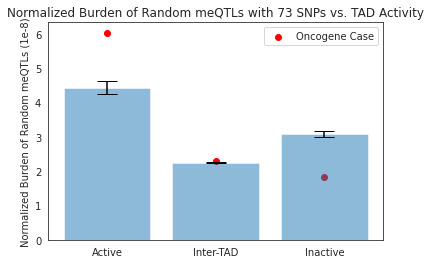

In [62]:
tad_activity1 = ['Active', 'Inter-TAD', 'Inactive']
x_pos1 = np.arange(len(tad_activity1))
CTEs1 = [active_mean_num_onco, boundary_mean_num_onco, inactive_mean_num_onco]
error1 = [2*active_std_onco/np.sqrt(1000), 2*boundary_std_onco/np.sqrt(1000), 2*inactive_std_onco/np.sqrt(1000)]
fig1, ax1 = plt.subplots()
ax1.bar(x_pos1, CTEs1, yerr=error1, align='center', alpha=0.5, ecolor='black', capsize=10)
ax1.set_ylabel('Normalized Burden of Random meQTLs (1e-8)')
ax1.set_xticks(x_pos1)
ax1.set_xticklabels(tad_activity1)
ax1.set_title('Normalized Burden of Random meQTLs with 73 SNPs vs. TAD Activity')
ax1.yaxis.grid(True)
ax1.scatter(x_pos1[0], onco_meqtls_clumped["TAD_TYPE"].value_counts()["Active"]/num_pairs_tads[0], color = "red")
ax1.scatter(x_pos1[1], onco_meqtls_clumped["TAD_TYPE"].value_counts()["Boundary"]/num_pairs_boundary, color = "red")
ax1.scatter(x_pos1[2], onco_meqtls_clumped["TAD_TYPE"].value_counts()["Inactive"]/num_pairs_tads[1], color = "red")
plt.grid(False)
ax1.yaxis.get_offset_text().set_visible(False)
plt.legend(["Oncogene Case"], loc="upper right")
plt.savefig("plots/oncogene_SNP_randomization.pdf")
plt.show()

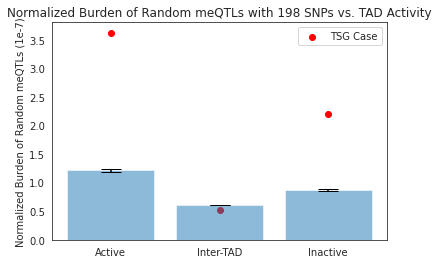

In [64]:
tad_activity2 = ['Active', 'Inter-TAD', 'Inactive']
x_pos2 = np.arange(len(tad_activity2))
CTEs2 = [active_mean_num_tsg, boundary_mean_num_tsg, inactive_mean_num_tsg]
error2 = [2*active_std_tsg/np.sqrt(1000), 2*boundary_std_tsg/np.sqrt(1000), 2*inactive_std_tsg/np.sqrt(1000)]
fig2, ax2 = plt.subplots()
ax2.bar(x_pos2, CTEs2, yerr=error2, align='center', alpha=0.5, ecolor='black', capsize=10)
ax2.set_ylabel('Normalized Burden of Random meQTLs (1e-7)')
ax2.set_xticks(x_pos2)
ax2.set_xticklabels(tad_activity2)
ax2.set_title('Normalized Burden of Random meQTLs with 198 SNPs vs. TAD Activity')
ax2.yaxis.grid(True)
ax2.scatter(x_pos2[0], tsg_meqtls_clumped["TAD_TYPE"].value_counts()["Active"]/num_pairs_tads[0], color = "red")
ax2.scatter(x_pos2[1], tsg_meqtls_clumped["TAD_TYPE"].value_counts()["Boundary"]/num_pairs_boundary, color = "red")
ax2.scatter(x_pos2[2], tsg_meqtls_clumped["TAD_TYPE"].value_counts()["Inactive"]/num_pairs_tads[1], color = "red")
plt.grid(False)
ax2.yaxis.get_offset_text().set_visible(False)
plt.legend(["TSG Case"], loc="upper right")
plt.savefig("plots/tsg_clumped_SNP_randomization.pdf")
plt.show()

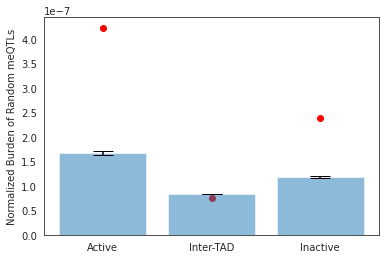

In [46]:
tad_activity3 = ['Active', 'Inter-TAD', 'Inactive']
x_pos3 = np.arange(len(tad_activity3))
CTEs3 = [active_mean_num_all, boundary_mean_num_all, inactive_mean_num_all]
error3 = [2*active_std_all/np.sqrt(1000), 2*boundary_std_all/np.sqrt(1000), 2*inactive_std_all/np.sqrt(1000)]
fig3, ax3 = plt.subplots()
ax3.bar(x_pos3, CTEs3, yerr=error3, align='center', alpha=0.5, ecolor='black', capsize=10)
ax3.set_ylabel('Normalized Burden of Random meQTLs')
ax3.set_xticks(x_pos3)
ax3.set_xticklabels(tad_activity3)
#ax3.set_title('Normalized Burden of Random meQTLs with 271 SNPs (1e-7) vs. TAD Activity')
ax3.yaxis.grid(True)
ax3.scatter(x_pos3[0], all_meqtl_mafs["TAD_Type"].value_counts()["Active"]/num_pairs_tads[0], color = "red")
ax3.scatter(x_pos3[1], all_meqtl_mafs["TAD_Type"].value_counts()["Boundary"]/num_pairs_boundary, color = "red")
ax3.scatter(x_pos3[2], all_meqtl_mafs["TAD_Type"].value_counts()["Inactive"]/num_pairs_tads[1], color = "red")
plt.grid(False)
#ax.ticklabel_format(useOffset=False)
#plt.savefig("plots/all_clumped_SNP_randomization.pdf")
plt.show()